In [1]:
import pandas as pd
import numpy as np
import re
import string
import unicodedata
import plotly_express as px
import plotly.io as pio
from sklearn import preprocessing
import pandas_profiling
import datetime
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt 
from sklearn import preprocessing
import warnings
import math
import plotly.express as px
import statsmodels
import scipy
import sklearn
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing


import math


warnings.filterwarnings("ignore")

# scipy
print('scipy: %s' % scipy.__version__)
# numpy
print('numpy: %s' % np.__version__)
# matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
print('pandas: %s' % pd.__version__)
# scikit-learn
print('sklearn: %s' % sklearn.__version__)
# statsmodels
print('statsmodels: %s' % statsmodels.__version__)
#print('unicodedata: %s' % unicodedata.__version__)

scipy: 1.4.1
numpy: 1.18.2
matplotlib: 3.2.1
pandas: 1.0.3
sklearn: 0.22.2.post1
statsmodels: 0.11.1


In [2]:
#verificar feriados 
def isHoliday(dia,mes):
    if dia == 1:
        if mes == 1 or mes ==5:
            return(True)
    if (dia ==2 or dia==15) and mes==11:
        return(True)
    if (dia ==7 or dia==20) and mes == 9:
        return(True)
    if mes == 4 and dia==21:
        return(True)    
    if mes==10 and (dia==12):
        return(True)
    if mes==12 and (dia ==25 or dia ==24):
        return(True)
    if mes==12 and dia==31:
        return(True)
    return(False)   

def AdjustFeriado(x):
    #print(x)
    if x['Feriado'] == 0 or x['Feriado'] == 1:
        return(x['Feriado'])
       # print('else')
       # print(x['Feriado'] >=0)
    else:
        dia = x['judgmentDate'].day
        mes = x['judgmentDate'].month 
        feriado = 0 if isHoliday(dia,mes) == True else 1
        return(feriado)
    
def AdjustWeekDay(x):    
    if x['weekDay'] > 0:
        return(x['weekDay'])
    else:
        return(x['judgmentDate'].weekday())        
    
def AdjustWeekType(x):    
    if x['weekType'] > 0:
        return(x['weekType'])
    else:
        weekType = 1 if x['judgmentDate'].weekday() <5 else 0
        return(weekType)     

In [3]:
from statsmodels.tsa.stattools import adfuller

def adf_teste(series,title='',prints=False):    
    summay = ''
    if prints:
        print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC',) 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():        
        out[f'critical value ({key})']=val
        
    if prints:
        display(pd.DataFrame(out))
    
    
    
    if result[1] <= 0.05:
        summary = "Strong evidence against the null hypothesis \n Reject the null hypothesis \n Data has no unit root and is stationary"
        if prints:
            print("Strong evidence against the null hypothesis")
            print("Reject the null hypothesis")
            print("Data has no unit root and is stationary")        
    else:
        summary = "Weak evidence against the null hypothesis \n Fail to reject the null hypothesis \n Data has a unit root and is non-stationary"
        if prints:
            print("Weak evidence against the null hypothesis")
            print("Fail to reject the null hypothesis")
            print("Data has a unit root and is non-stationary")
            
    
    return(result[1],title,result[0],result[2],result[3],result[4],result[5],summary) 

In [4]:
#carrega
df_count_day_type = pd.read_csv('./data_joao/df_count_day_type_modificado.csv',sep=",")#,parse_dates=['judgmentDate'])
df_count_week_day_type = pd.read_csv('./data_joao/df_count_week_day_type_modificado.csv',sep=",")
df_count_year_month_type = pd.read_csv('./data_joao/df_count_year_month_type_modificado.csv',sep=",")

dfUniqueTypes = df_count_day_type['type'].unique()

#cria indice
df_count_day_type.index = pd.to_datetime(df_count_day_type['judgmentDate'])
df_count_year_month_type.index = pd.to_datetime(df_count_year_month_type['yearMonth'])

#deleta colunas que sobraram da importacao e da criacao do indice
del df_count_day_type['Unnamed: 0']
del df_count_week_day_type['Unnamed: 0']
del df_count_year_month_type['Unnamed: 0']
del df_count_day_type['judgmentDate']
del df_count_year_month_type['yearMonth']

#calcula o total do dia
df_count_day_type['total'] = df_count_day_type.groupby(['judgmentDate'])['count'].agg('sum')
#salva as informacoes que nao serao pivotadas
ref = df_count_day_type[['weekDay','weekType','Feriado','total']]
#realiza o pivot
df_count_day_typeGRP = df_count_day_type.pivot(columns='type', values='count').fillna(0)

#transforma tudo pra int (count)
for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)
        
#faz o merge com as que foram salvas antes do pivot        
df_count_day_typeGRP = pd.merge(df_count_day_typeGRP,ref,on='judgmentDate',how='left')
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate').drop_duplicates()

#remove duplicadas e nulas pra fazer a frequencia diaria
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP = df_count_day_typeGRP.drop_duplicates()
df_count_day_typeGRP = df_count_day_typeGRP.dropna()


df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP['Feriado'].apply( lambda x: 0 if x==True else 1)
df_count_day_typeGRP['weekType'] = pd.get_dummies(df_count_day_typeGRP['weekType'])
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D') #precisa pois abaixo seto os que faltam

#reseta o indice agora com todos os dias inclusive vazios e seta as informaçoes das datas novas (sem dados)
df_count_day_typeGRP = df_count_day_typeGRP.reset_index()    
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP.apply(AdjustFeriado,axis=1)
df_count_day_typeGRP['weekDay'] = df_count_day_typeGRP.apply(AdjustWeekDay,axis=1)
df_count_day_typeGRP['weekType'] = df_count_day_typeGRP.apply(AdjustWeekType,axis=1)

#volta ao estado normal (com indice e frequencia)
df_count_day_typeGRP.index = df_count_day_typeGRP['judgmentDate']
del df_count_day_typeGRP['judgmentDate']
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D')

#seta para zerado as datas que nao existiam antes 
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)

for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)


In [5]:
df_count_day_typeGRP.head(3)
df = df_count_day_typeGRP
dfMonth = df.resample('MS').sum()
dfQuarter = df.resample('QS').sum()
dfYear = df.resample('Y').sum()

field = 'total'

In [6]:
display(dfYear.head(3))
display(df.head(3))

,Agravo,Agravo Embargos Infringentes,Agravo Inominado,Agravo Interno,Agravo Lei,Agravo Regimental,Agravo de Instrumento,Agravo de Instrumento em Recurso Extraordinario,Agravo de Petição,Agravo em Execução,...,Suspenção de Liminar ou Antecipação de Tutela,Termo Circunstanciado,Tutela Antecipada Antecedente,Tutela Cautelar Antecedente,Tutela Provisoria,Uniformização de Jurisprudência,weekDay,weekType,Feriado,total
judgmentDate,,,,,,,,,,,,,,,,,,,,,
2000-12-31,607,0,4,218,3,208,5141,0,0,5,...,0,0,0,0,0,0,1092,260,354,27076
2001-12-31,1649,0,0,576,8,259,7443,0,0,19,...,0,1,0,0,0,0,1092,261,354,49109
2002-12-31,2670,0,1,737,7,445,10726,0,0,44,...,0,0,0,0,0,2,1093,261,354,67173


,Agravo,Agravo Embargos Infringentes,Agravo Inominado,Agravo Interno,Agravo Lei,Agravo Regimental,Agravo de Instrumento,Agravo de Instrumento em Recurso Extraordinario,Agravo de Petição,Agravo em Execução,...,Suspenção de Liminar ou Antecipação de Tutela,Termo Circunstanciado,Tutela Antecipada Antecedente,Tutela Cautelar Antecedente,Tutela Provisoria,Uniformização de Jurisprudência,weekDay,weekType,Feriado,total
judgmentDate,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,1,1,2
2000-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
2000-01-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,1,1,0


In [162]:
def MakePredictionsTestAndForecast(modelType,dfParam,
                                   field,testPercentSize,
                                   start_p=2,start_q=2,max_p=5,max_q=5,max_d=2,d=None,seasonal=False,seasonalM=7,
                                   futureEstimation=30,exogField='',
                                   holtAlpha=12, holtTrend='add',figsizeX=30,figsizeY=15):

    figsize=(figsizeX,figsizeY)
  #  
    dfInt = dfParam.copy()
  #  
    if adf_teste(dfParam[field],'',False)[0] >0.05:
        dfInt[field] = diff(dfInt[field],k_diff=1)
        print('Série não estacionaria, aplicado Fuller!')
        dfInt = dfInt.dropna()        
    else:
        dfInt = dfInt
       
    #display(dfInt.head(3))
        
        
    test_size = (len(dfInt) - int((testPercentSize * len(dfInt))/100))
    train = dfInt.iloc[:test_size]
    test = dfInt.iloc[test_size:]    
    #print('ADF Test:',adf_test(dfInt[field]))       
    #print('ADF Test:',adf_test(dfInt[field]))
    
    print("Tamanho do treino: ", str(len(train)))
    print("Tamanho do teste: ", str(len(test)))
    print('test Size:',test_size)
    start=len(train)
    end=len(train)+len(test)-1
    
    title = ''#Real Manufacturing and Trade Inventories'
    ylabel=''
    xlabel='' # we don't really need a label here
    
    if modelType == 'SMOOTHING':
        alpha = 2/(holtAlpha+1)
        alphaStr = str(alpha)
        dfSmooth = dfInt
        dfSmooth = dfSmooth[[field]]
        dfSmooth['SimSmooth_'+alphaStr] = SimpleExpSmoothing(df[field]).fit(smoothing_level=holtAlpha, optimized=False).fittedvalues.shift(-1)
        dfSmooth['ExpSmooth_'+alphaStr] = ExponentialSmoothing(df[field],trend=holtTrend).fit().fittedvalues.shift(-1)
        dfSmooth['SeasonalExpSmooth_'+alphaStr] = ExponentialSmoothing(dfSmooth[field],trend=holtTrend,seasonal=holtTrend,seasonal_periods=seasonalM).fit().fittedvalues
        #dfSmooth = dfSmooth.apply(lambda x: np.sqrt(x.dot(x)), axis=1)
        ax = dfInt[field].plot(legend=True,figsize=figsize,title=title)
        dfSmooth['ExpSmooth_'+alphaStr].plot(legend=True,linestyle='dashed')
        dfSmooth['SeasonalExpSmooth_'+alphaStr].plot(legend=True,linestyle='dashed')
        #df.replace([np.inf, -np.inf], np.nan)

        ax.autoscale(axis='x',tight=True)        
        #isplay(dfSmooth)
        return
    
    
    if seasonal == True:
        autoArimaResults = auto_arima(dfInt[field],start_p=0,start_q=0,max_q=max_q,max_p=max_p,d=d,max_d=max_d,seasonal=seasonal,m=seasonalM,trace=False)
    else:
        autoArimaResults = auto_arima(dfInt[field],start_p=0,start_q=0,max_q=max_q,max_p=max_p,d=d,max_d=max_d,trace=False)
        
    print(f'ORDER: {autoArimaResults.order}')
    print(f'SEASONAL ORDER: {autoArimaResults.seasonal_order}')
        
    if modelType == 'ARIMA':        
        model = ARIMA(train[field],order=autoArimaResults.order)
    if modelType == 'SARIMA':
        model = SARIMAX(train[field],order=autoArimaResults.order,seasonal_order=autoArimaResults.seasonal_order)
    if modelType == 'SARIMAX':
        model = SARIMAX(train[field],order=autoArimaResults.order,seasonal_order=autoArimaResults.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)                
    results = model.fit()
    results.summary()
    
    print('Executando ' + modelType + ' Param order: '+ str(autoArimaResults.order))
    
    if modelType == 'ARIMA':
        predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(f'{modelType}{autoArimaResults.order} Predictions')
    if modelType == 'SARIMA':
        predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(f'{modelType}{autoArimaResults.order}{autoArimaResults.seasonal_order} Predictions')
    if modelType == 'SARIMAX':
        exog_forecast = test[exogField]
        predictions = results.predict(start=start, end=end, exog=exog_forecast, typ='levels').rename(f'{modelType}{autoArimaResults.order}{autoArimaResults.seasonal_order} Predictions')
        
    ax = test[field].rename('test '+field).plot(legend=True,figsize=figsize,title=title)
    predictions.plot(legend=True)
    ax.autoscale(axis='x',tight=True)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    if modelType == 'SARIMAX':
        print('incluindo feriados')
        for x in test.query('Feriado==0').index: 
            ax.axvline(x=x, color='k', alpha = 0.3);
    
    error = mean_squared_error(test[field], predictions)
    print(f'{modelType}{autoArimaResults.order} MSE Error: {error:11.10}')
    error = rmse(test[field], predictions)
    print(f'{modelType}{autoArimaResults.order} RMSE Error: {error:11.10}')
    
    for i in range(len(predictions)):
        print(f"predicted={predictions[i]:<11.10}, expected={test[field][i]}")
  
    
    #FORECAST
    if modelType == 'ARIMA':
        model = ARIMA(dfInt[field],order=autoArimaResults.order)
    if modelType == 'SARIMA':
        model = SARIMAX(dfInt[field],order=autoArimaResults.order,seasonal_order=autoArimaResults.seasonal_order)
    if modelType == 'SARIMAX':
        model = SARIMAX(dfInt[field],exog=dfInt[exogField],order=autoArimaResults.order,seasonal_order=autoArimaResults.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)
    print(model.fit())
    results = model.fit()
    
    if modelType == 'ARIMA':
        fcast = results.predict(len(dfInt),len(dfInt)+futureEstimation,typ='levels').rename(f'{modelType}{autoArimaResults.order} Forecast')        
    if modelType == 'SARIMA':
        fcast = results.predict(len(dfInt),len(dfInt)+futureEstimation,typ='levels').rename(f'{modelType}{autoArimaResults.order}{autoArimaResults.seasonal_order}  Forecast')
    if modelType == 'SARIMAX':        
        exog_forecast = dfInt[:futureEstimation+1][exogField]
        print(len(dfInt))
        #display(exog_forecast)
        fcast = results.predict(len(dfInt),len(dfInt)+futureEstimation,exog=exog_forecast,typ='levels').rename(f'{modelType}{autoArimaResults.order}{autoArimaResults.seasonal_order}  Forecast')
    
    
    if modelType in ['SARIMA','SARIMAX','ARIMA']:        
        ax = dfInt[field].plot(legend=True,figsize=figsize,title=title)
        fcast.plot(legend=True,linestyle='dashed')
        ax.autoscale(axis='x',tight=True)
        ax.set(xlabel=xlabel, ylabel=ylabel)
        
        expected = test[field].values
        predictions = predictions.values
        forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
        bias = sum(forecast_errors) * 1.0/len(expected)
        print('Bias: %f' % bias)
    
    
    #n = len(dfInt)
    #i = math.ceil(train*n)
    #xTrain = np.arange(1,i)
    #xTest = np.arange((i+1),n)
    
    

In [141]:
def MakePredictionsTestPerformance(dfParam,
                                   field,testPercentSize,
                                   start_p=2,start_q=2,max_p=5,max_q=5,max_d=2,d=None,seasonal=False,seasonalM=7,
                                   futureEstimation=30,exogField=''):
    resultTestPerform = []
    
    for modelo in ['ARIMA','SARIMA','SARIMAX']:
        try:
            
            modelType = modelo
            
        
            dfInt = dfParam.copy()
            
            #if adf_teste(dfParam[field],'',False)[0] >0.05:
            #    dfInt[field] = diff(dfInt[field],k_diff=1)
            #    serieEstacionaria = 'Não'
            #    dfInt = dfInt.dropna()        
            #else:
            #    dfInt = dfInt
            #    serieEstacionaria = 'Sim'
    
            test_size = (len(dfInt) - int((testPercentSize * len(dfInt))/100))
            train = dfInt.iloc[:test_size]
            test = dfInt.iloc[test_size:]        
                        
            #print("Tamanho do treino: ", str(len(train)))
            #print("Tamanho do teste: ", str(len(test)))
            #print('test Size:',test_size)
            start=len(train)
            end=len(train)+len(test)-1
            
            title = ''
            ylabel=''
            xlabel='' 
           
            #display(dfInt)
           
            if seasonal == True:
                autoArimaResults = auto_arima(dfInt[field],start_p=0,start_q=0,max_q=max_q,max_p=max_p,d=d,max_d=max_d,seasonal=seasonal,m=seasonalM,trace=False)
            else:
                autoArimaResults = auto_arima(dfInt[field],start_p=0,start_q=0,max_q=max_q,max_p=max_p,d=d,max_d=max_d,trace=False)
                
            
                
            if modelType == 'ARIMA':        
                model = ARIMA(train[field],order=autoArimaResults.order)
            if modelType == 'SARIMA':
                model = SARIMAX(train[field],order=autoArimaResults.order,seasonal_order=autoArimaResults.seasonal_order)
            if modelType == 'SARIMAX':
                model = SARIMAX(train[field],order=autoArimaResults.order,seasonal_order=autoArimaResults.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)                
            results = model.fit()
            
            #print('Executando ' + modelType + ' Param order: '+ str(autoArimaResults.order))
            
            if modelType == 'ARIMA':
                predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(f'{modelType}{autoArimaResults.order} Predictions')
            if modelType == 'SARIMA':
                predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(f'{modelType}{autoArimaResults.order}{autoArimaResults.seasonal_order} Predictions')
            if modelType == 'SARIMAX':
                exog_forecast = test[exogField]
                predictions = results.predict(start=start, end=end, exog=exog_forecast, typ='levels').rename(f'{modelType}{autoArimaResults.order}{autoArimaResults.seasonal_order} Predictions')
                
            errorMean = mean_squared_error(test[field], predictions)
            #print(f'{modelType}{autoArimaResults.order} MSE Error: {errorMean:11.10}')
            errorRmse = rmse(test[field], predictions)
            #print(f'{modelType}{autoArimaResults.order} RMSE Error: {errorRmse:11.10}')       
          
            #FORECAST
            if modelType == 'ARIMA':
                model = ARIMA(dfInt[field],order=autoArimaResults.order)
            if modelType == 'SARIMA':
                model = SARIMAX(dfInt[field],order=autoArimaResults.order,seasonal_order=autoArimaResults.seasonal_order)
            if modelType == 'SARIMAX':
                model = SARIMAX(dfInt[field],exog=dfInt[exogField],order=autoArimaResults.order,seasonal_order=autoArimaResults.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)
            #print(model.fit())
            results = model.fit()
            
            if modelType == 'ARIMA':
                fcast = results.predict(len(dfInt),len(dfInt)+futureEstimation,typ='levels').rename(f'{modelType}{autoArimaResults.order} Forecast')        
            if modelType == 'SARIMA':
                fcast = results.predict(len(dfInt),len(dfInt)+futureEstimation,typ='levels').rename(f'{modelType}{autoArimaResults.order}{autoArimaResults.seasonal_order}  Forecast')
            if modelType == 'SARIMAX':        
                exog_forecast = dfInt[:futureEstimation+1][exogField]
                #print(len(dfInt))
                #display(exog_forecast)
                fcast = results.predict(len(dfInt),len(dfInt)+futureEstimation,exog=exog_forecast,typ='levels').rename(f'{modelType}{autoArimaResults.order}{autoArimaResults.seasonal_order}  Forecast')
            
            expected = test[field].values
            predictions = predictions.values
            forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
            bias = sum(forecast_errors) * 1.0/len(expected)                
            
            meanAbsolError = mean_absolute_error(expected, predictions)
    
            
            resultTestPerform.append({'Modelo':modelType,
                                      'Serie':field,
                                      'Estacionária':serieEstacionaria,
                                      'Ordem':autoArimaResults.order,
                                      'Ordem Sazonal': autoArimaResults.seasonal_order,
                                      'Média de valores do modelo':dfInt[field].mean(),
                                      'MeanSquaredError':errorMean,
                                      'RootMeanSquaredError':errorRmse,
                                      'MeanAbsoluteError':meanAbsolError,                                  
                                      'Bias':bias
                                     })
        except:
               print(f'Erro em {field}')
            #print(f'{modelType} verificado!')
        #display(pd.DataFrame(resultTestPerform))
    return(resultTestPerform)

In [55]:
MakePredictionsTestPerformance(dfMonth['2014-01-11':],'Apelação Rec',testPercentSize=30,
                               seasonal=True,seasonalM=12,futureEstimation=30,
                               exogField='weekType')

[{'Modelo': 'ARIMA',
  'Serie': 'Apelação Rec',
  'Estacionária': 'Sim',
  'Ordem': (0, 0, 0),
  'Ordem Sazonal': (0, 0, 0, 0),
  'Média de valores do modelo': 0.0,
  'MeanSquaredError': 1.4163500993863562e-11,
  'RootMeanSquaredError': 3.7634427050060906e-06,
  'MeanAbsoluteError': 3.7634427050060894e-06,
  'Bias': 3.7634427050060902e-06},
 {'Modelo': 'SARIMA',
  'Serie': 'Apelação Rec',
  'Estacionária': 'Sim',
  'Ordem': (0, 0, 0),
  'Ordem Sazonal': (0, 0, 0, 0),
  'Média de valores do modelo': 0.0,
  'MeanSquaredError': 0.0,
  'RootMeanSquaredError': 0.0,
  'MeanAbsoluteError': 0.0,
  'Bias': 0.0},
 {'Modelo': 'SARIMAX',
  'Serie': 'Apelação Rec',
  'Estacionária': 'Sim',
  'Ordem': (0, 0, 0),
  'Ordem Sazonal': (0, 0, 0, 0),
  'Média de valores do modelo': 0.0,
  'MeanSquaredError': 0.0,
  'RootMeanSquaredError': 0.0,
  'MeanAbsoluteError': 0.0,
  'Bias': 0.0}]

In [74]:
resultados= []
for i in dfUniqueTypes[0:]:
    print(i)   
    resultados.append(MakePredictionsTestPerformance(dfMonth['2014-01-11':],i,testPercentSize=30,
                               seasonal=True,seasonalM=12,futureEstimation=30,
                               exogField=['weekDay','Feriado','weekType']))

Agravo de Instrumento

Apelação Cível

Apelação e Reexame Necessário

Agravo

Reexame Necessário

Agravo Regimental

Embargos de Declaração

Apelação Crime

Ação Rescisória

Conflito de Competência

Agravo Interno

Exceção de Suspeição

Mandado de Segurança

Habeas Corpus

Outros Feitos

Impugnação ao Valor da Causa

Medida Cautelar

Medida Cautelar Inominada

Outros Incidentes

Recurso Crime

Recurso em Sentido Estrito

Processo Crime

Recurso de Ofício

Correição Parcial

Conflito de Jurisdição

Agravo Lei

Queixa

Agravo em Execução

Recurso de Agravo

Agravo Inominado

Cautelar Incidental

Desaforamento

Embargos Infringentes

Embargos à Execução

Cautelar Inominada

Carta Testemunhável

Habeas Data

Termo Circunstanciado

Exceção da Verdade

Inquérito Policial

Interpelação Judicial

Exceção de Incompetência

Representação

Pedido de Assistência Judiciária Gratuita

Impugnação à Assistência Judiciária

Restauração de Autos

Declaração de Inconstitucionalidade

Uniformização de Jur

In [95]:
display(pd.DataFrame(resultados))
ress = [] 
for i in resultados:
    if len(i)>=1:
        ress.append(i[0])
        if len(i)>=2:
            ress.append(i[1])
            if len(i)>=3:
                ress.append(i[2])
    
#display(pd.DataFrame(ress))

    
SarimasResults = pd.DataFrame(ress) #.plot.scatter(x='MeanSquaredError',y='Serie'

display(SarimasResults.sort_values(by ='MeanSquaredError',ascending=False))

,0,1,2
0,"{'Modelo': 'ARIMA', 'Serie': 'Agravo de Instru...","{'Modelo': 'SARIMA', 'Serie': 'Agravo de Instr...","{'Modelo': 'SARIMAX', 'Serie': 'Agravo de Inst..."
1,"{'Modelo': 'ARIMA', 'Serie': 'Apelação Cível',...","{'Modelo': 'SARIMA', 'Serie': 'Apelação Cível'...","{'Modelo': 'SARIMAX', 'Serie': 'Apelação Cível..."
2,"{'Modelo': 'ARIMA', 'Serie': 'Apelação e Reexa...","{'Modelo': 'SARIMA', 'Serie': 'Apelação e Reex...","{'Modelo': 'SARIMAX', 'Serie': 'Apelação e Ree..."
3,"{'Modelo': 'ARIMA', 'Serie': 'Agravo', 'Estaci...","{'Modelo': 'SARIMA', 'Serie': 'Agravo', 'Estac...","{'Modelo': 'SARIMAX', 'Serie': 'Agravo', 'Esta..."
4,"{'Modelo': 'ARIMA', 'Serie': 'Reexame Necessár...","{'Modelo': 'SARIMA', 'Serie': 'Reexame Necessá...","{'Modelo': 'SARIMAX', 'Serie': 'Reexame Necess..."
...,...,...,...
114,"{'Modelo': 'ARIMA', 'Serie': 'Tutela Cautelar ...","{'Modelo': 'SARIMA', 'Serie': 'Tutela Cautelar...","{'Modelo': 'SARIMAX', 'Serie': 'Tutela Cautela..."
115,"{'Modelo': 'ARIMA', 'Serie': 'Tutela Antecipad...","{'Modelo': 'SARIMAX', 'Serie': 'Tutela Antecip...",None
116,"{'Modelo': 'ARIMA', 'Serie': 'Tutela Provisori...","{'Modelo': 'SARIMA', 'Serie': 'Tutela Provisor...","{'Modelo': 'SARIMAX', 'Serie': 'Tutela Proviso..."
117,None,None,None


,Modelo,Serie,Estacionária,Ordem,Ordem Sazonal,Média de valores do modelo,MeanSquaredError,RootMeanSquaredError,MeanAbsoluteError,Bias
205,SARIMAX,Reclamação,Não,"(1, 0, 3)","(0, 1, 0, 12)",0.652174,2.041164e+08,14286.931914,7473.835849,-2103.476468
5,SARIMAX,Apelação Cível,Sim,"(1, 0, 0)","(0, 0, 1, 12)",8257.468085,6.336913e+06,2517.322630,2179.808732,1399.346926
3,ARIMA,Apelação Cível,Sim,"(1, 0, 0)","(0, 0, 1, 12)",8257.468085,5.905999e+06,2430.226040,1785.826554,-1704.693425
4,SARIMA,Apelação Cível,Sim,"(1, 0, 0)","(0, 0, 1, 12)",8257.468085,5.355870e+06,2314.275184,1981.362509,1109.249364
0,ARIMA,Agravo de Instrumento,Sim,"(2, 1, 1)","(1, 0, 1, 12)",7341.510638,2.378717e+06,1542.308981,983.471641,-641.963869
...,...,...,...,...,...,...,...,...,...,...
216,SARIMA,Impugnação,Sim,"(0, 0, 0)","(0, 0, 0, 0)",0.000000,0.000000e+00,0.000000,0.000000,0.000000
211,SARIMAX,Exceção Suspeição Impedimento,Sim,"(0, 0, 0)","(0, 0, 0, 0)",0.000000,0.000000e+00,0.000000,0.000000,0.000000
210,SARIMA,Exceção Suspeição Impedimento,Sim,"(0, 0, 0)","(0, 0, 0, 0)",0.000000,0.000000e+00,0.000000,0.000000,0.000000
208,SARIMAX,Outros Cíveis,Sim,"(0, 0, 0)","(0, 0, 0, 0)",0.000000,0.000000e+00,0.000000,0.000000,0.000000


In [109]:
scatter_plot_top20_year = px.scatter(SarimasResults, x="RootMeanSquaredError", y="MeanSquaredError",color='Serie')
pio.show(scatter_plot_top20_year)


Série não estacionaria, aplicado Fuller!
Tamanho do treino:  49
Tamanho do teste:  21
test Size: 49
ORDER: (0, 0, 1)
SEASONAL ORDER: (0, 1, 1, 12)
Executando SARIMAX Param order: (0, 0, 1)
incluindo feriados
SARIMAX(0, 0, 1) MSE Error:  10011341.4
SARIMAX(0, 0, 1) RMSE Error: 3164.070385
predicted=-696.3437235, expected=-2307.0
predicted=-1103.0    , expected=2083.0
predicted=-260.0     , expected=1215.0
predicted=1468.0     , expected=-1861.0
predicted=-602.0     , expected=1793.0
predicted=573.0      , expected=-1478.0
predicted=-4829.0    , expected=-1260.0
predicted=5734.0     , expected=476.0
predicted=-4513.0    , expected=-1303.0
predicted=-2720.0    , expected=-4894.0
predicted=961.0      , expected=3546.0
predicted=4367.0     , expected=3502.0
predicted=-696.3437235, expected=-2122.0
predicted=-1103.0    , expected=1341.0
predicted=-260.0     , expected=-1228.0
predicted=1468.0     , expected=528.0
predicted=-602.0     , expected=1734.0
predicted=573.0      , expected=-2265.0


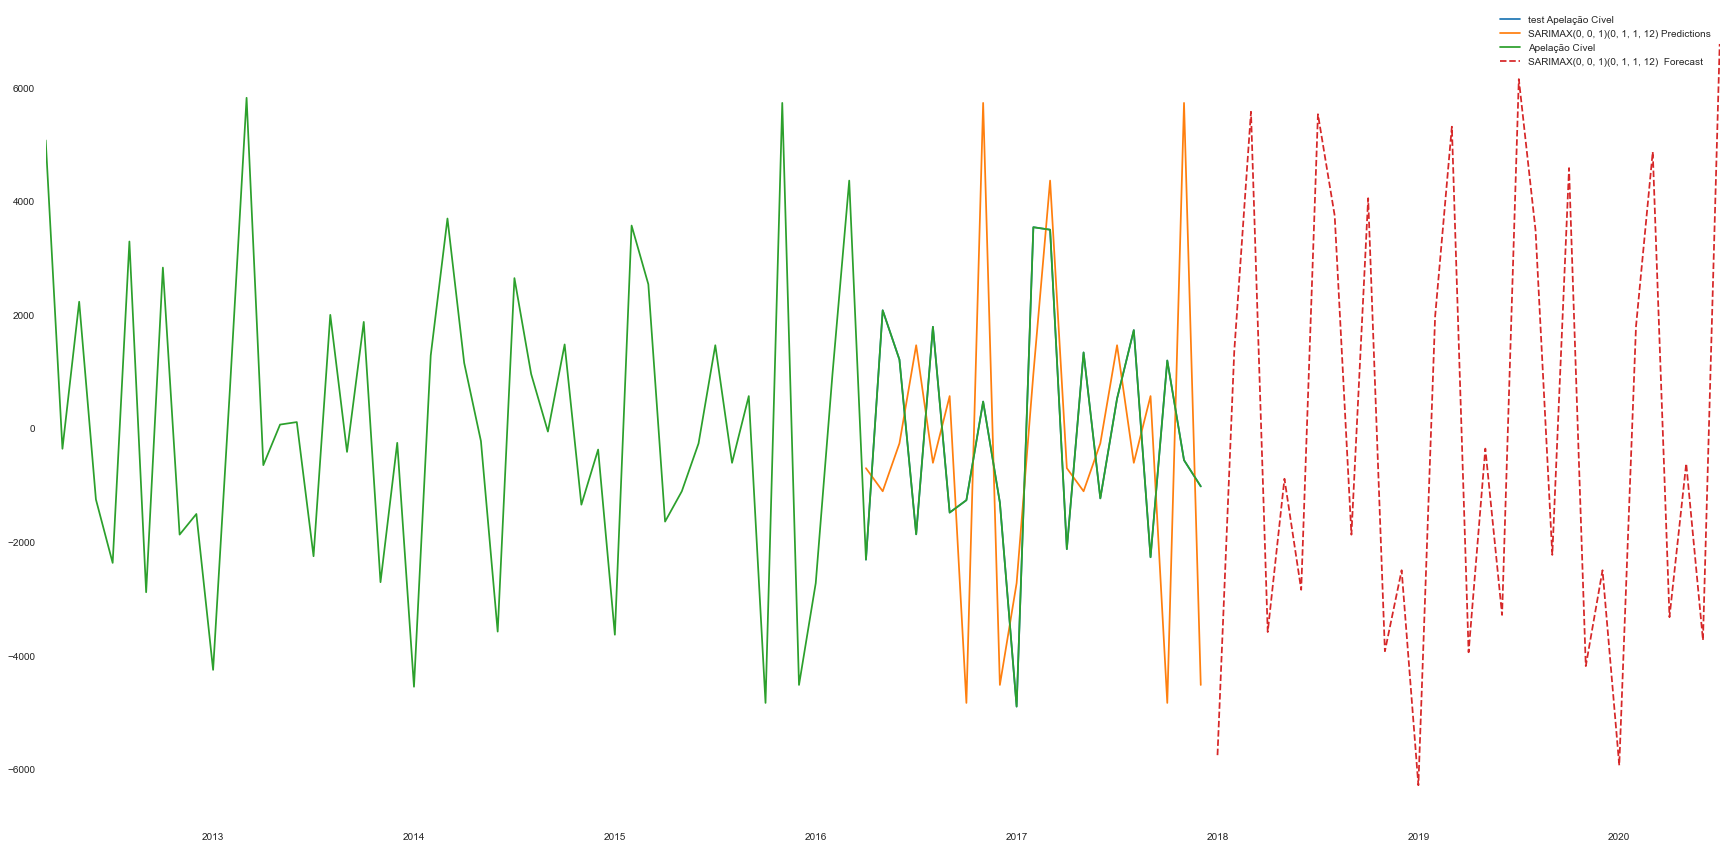

In [163]:
MakePredictionsTestAndForecast('SARIMAX',dfMonth['2012-01-11':],dfUniqueTypes[1],testPercentSize=30,
                               seasonal=True,seasonalM=12,futureEstimation=30,exogField=['weekDay','Feriado','weekType'],holtAlpha=12,holtTrend='add')

#SARIMAX(0, 0, 1) MSE Error:  10011341.4
#SARIMAX(0, 0, 1) RMSE Error: 3164.070385


#SARIMAX(0, 0, 2) MSE Error: 48059676.55
#SARIMAX(0, 0, 2) RMSE Error: 6932.508677

# SARIMAX 

## DAILY

Tamanho do treino:  1559
Tamanho do teste:  668
test Size: 1559
Executando SARIMAX Param order: (0, 0, 0)
incluindo feriados
SARIMAX(0, 0, 0) MSE Error: 0.002994011976
SARIMAX(0, 0, 0) RMSE Error: 0.05471756552
2227
Bias: 0.002994


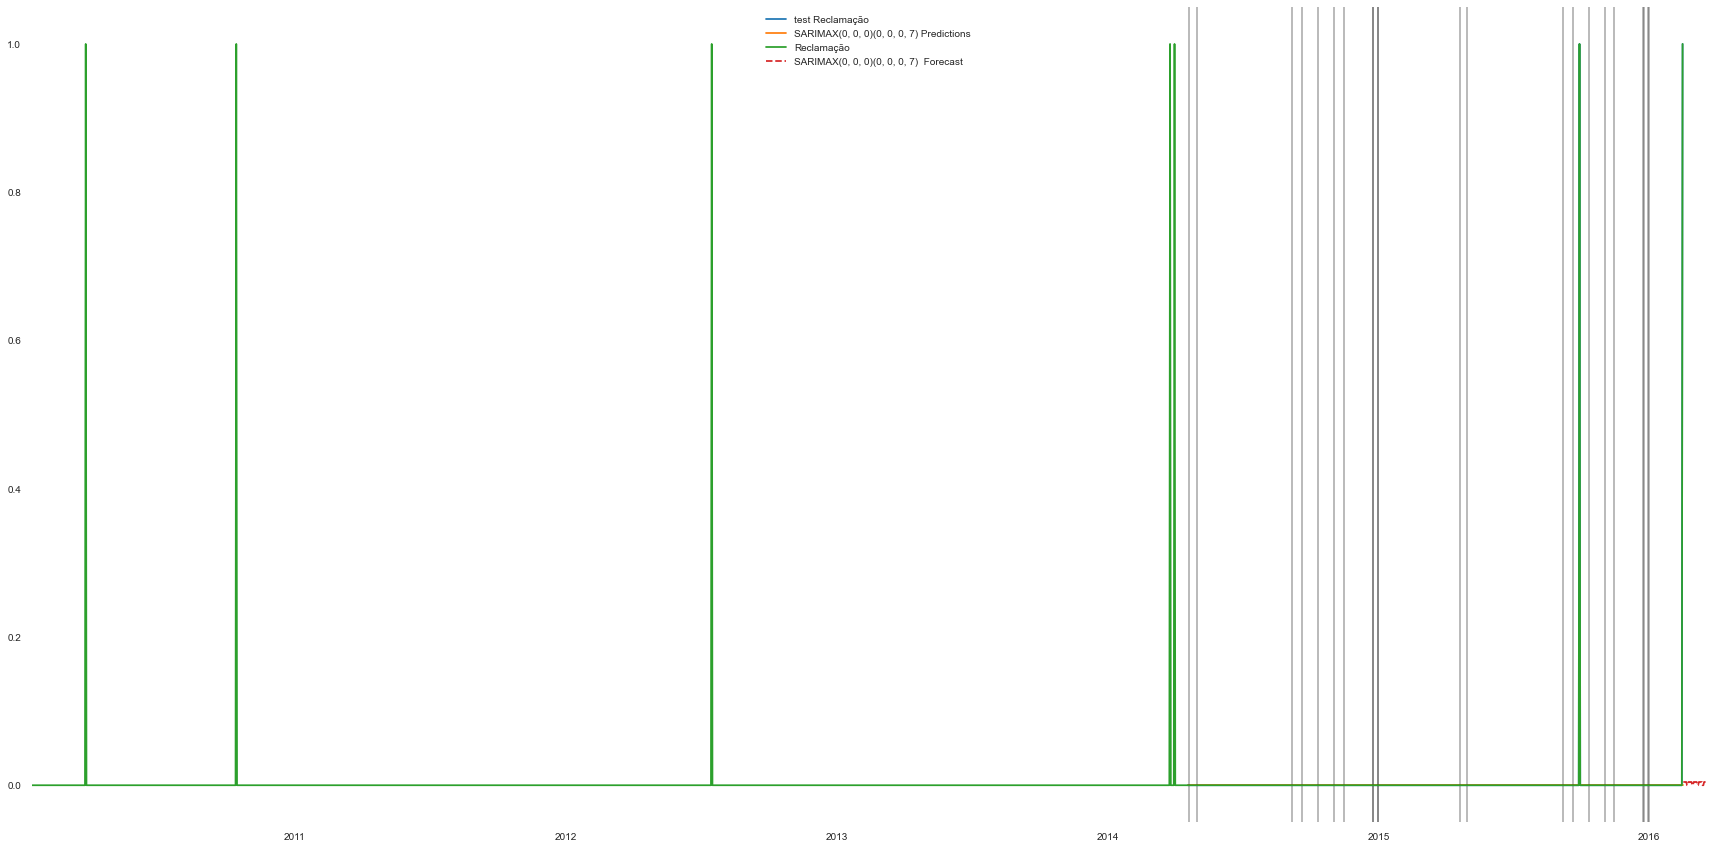

In [126]:
MakePredictionsTestAndForecast('SARIMAX',df['2010-01-11':'2016-02-15'],'Reclamação',testPercentSize=30,
                               seasonal=True,seasonalM=7,futureEstimation=30,exogField='weekType')

## MONTH

In [154]:
MakePredictionsTestAndForecast('SARIMAX',dfMonth['2012-01-11':],'Apelação Cível',testPercentSize=30,
                               seasonal=True,seasonalM=12,futureEstimation=12,exogField=['Feriado'])

#
#Série não estacionaria, aplicado Fuller!
#Tamanho do treino:  84
#Tamanho do teste:  35
#test Size: 84
#Executando SARIMAX Param order: (0, 0, 1)
#incluindo feriados
#SARIMAX(0, 0, 1) MSE Error: 66195472.64
#SARIMAX(0, 0, 1) RMSE Error:  8136.06002
#<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x13ba0e810>
#119
#Bias: -199.898984

Tamanho do treino:  50
Tamanho do teste:  21
test Size: 50
ORDER: (0, 0, 2)
SEASONAL ORDER: (0, 0, 2, 12)
Executando SARIMAX Param order: (0, 0, 2)


NameError: name 'figsize' is not defined

# SARIMA 

## DAILY

Tamanho do treino:  1559
Tamanho do teste:  668
test Size: 1559
Executando SARIMA Param order: (1, 0, 0)
SARIMA(1, 0, 0) MSE Error: 1062120.538
SARIMA(1, 0, 0) RMSE Error: 1030.592324
Bias: -53.933547


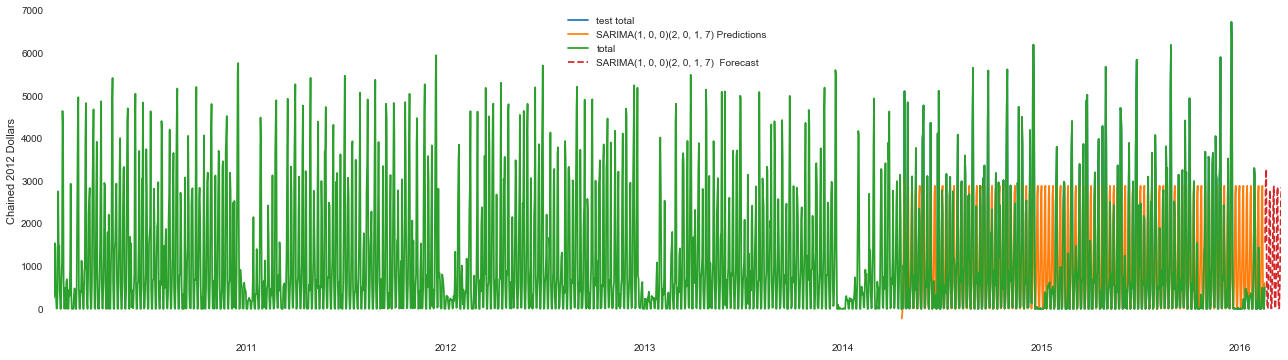

In [166]:
MakePredictionsTestAndForecast('SARIMA',df['2010-01-11':'2016-02-15'],'total',testPercentSize=30,
                               seasonal=True,seasonalM=7,futureEstimation=30)

## MONTH

Tamanho do treino:  27
Tamanho do teste:  8
test Size: 27
Executando SARIMA Param order: (0, 0, 0)
SARIMA(0, 0, 0) MSE Error: 20802322.75
SARIMA(0, 0, 0) RMSE Error: 4560.956342
Bias: -2650.000000


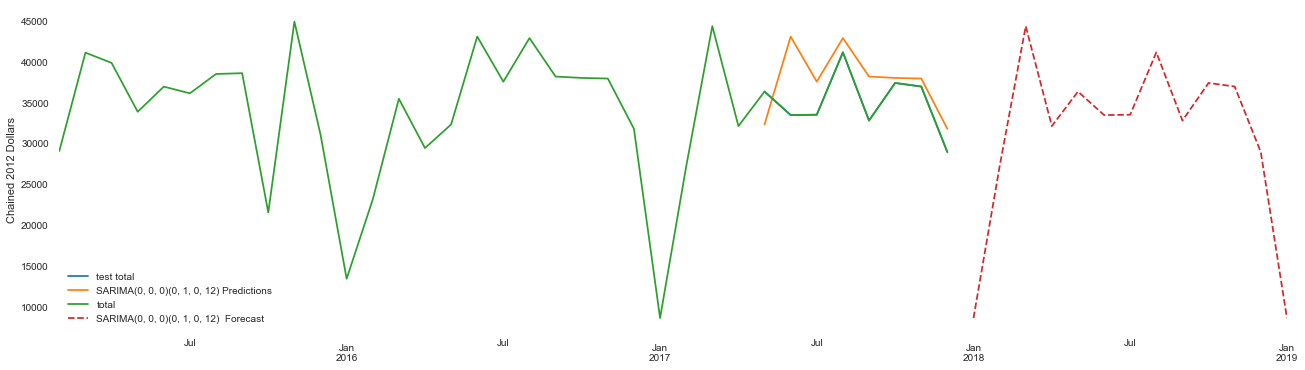

In [129]:
MakePredictionsTestAndForecast('SARIMA',dfMonth['2015-01-11':],'total',testPercentSize=25,
                               seasonal=True,seasonalM=12,futureEstimation=12)

# ARIMA 

## DAILY

Tamanho do treino:  981
Tamanho do teste:  327
test Size: 981
Executando ARIMA Param order: (1, 0, 0)
ARIMA(1, 0, 0) MSE Error: 2426974.501
ARIMA(1, 0, 0) RMSE Error: 1557.874995


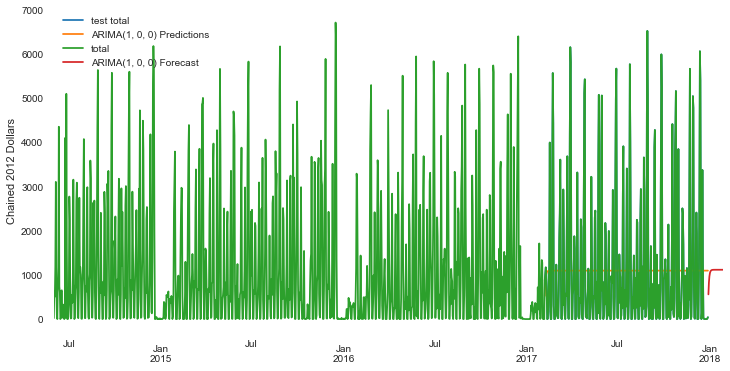

In [186]:
MakePredictionsTestAndForecast('ARIMA',df['2014-06-01':],'total',testPercentSize=25,
                               seasonal=True,seasonalM=7,futureEstimation=30)

## MONTH


Série não estacionaria, aplicado Fuller!
Tamanho do treino:  36
Tamanho do teste:  11
test Size: 36
Executando ARIMA Param order: (1, 0, 1)
ARIMA(1, 0, 1) MSE Error: 53219934.43
ARIMA(1, 0, 1) RMSE Error:  7295.19941
Bias: -323.659632


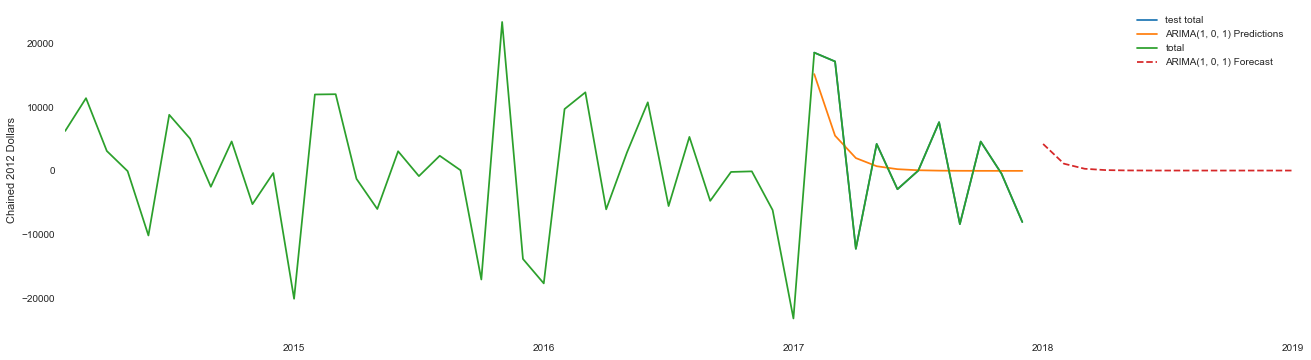

In [125]:
MakePredictionsTestAndForecast('ARIMA',dfMonth,'total',testPercentSize=25,
                               seasonal=False,seasonalM=12,futureEstimation=12)

Série não estacionaria, aplicado Fuller!
Tamanho do treino:  33
Tamanho do teste:  14
test Size: 33
Série não estacionaria, aplicado Fuller!
Tamanho do treino:  33
Tamanho do teste:  14
test Size: 33
Executando SARIMA Param order: (0, 0, 1)
SARIMA(0, 0, 1) MSE Error: 45320229.88
SARIMA(0, 0, 1) RMSE Error: 6732.030146
Bias: -957.772247
Série não estacionaria, aplicado Fuller!
Tamanho do treino:  33
Tamanho do teste:  14
test Size: 33
Executando SARIMAX Param order: (0, 0, 1)
incluindo feriados
SARIMAX(0, 0, 1) MSE Error: 160383182.8
SARIMAX(0, 0, 1) RMSE Error: 12664.24821
47
Bias: -818.131136


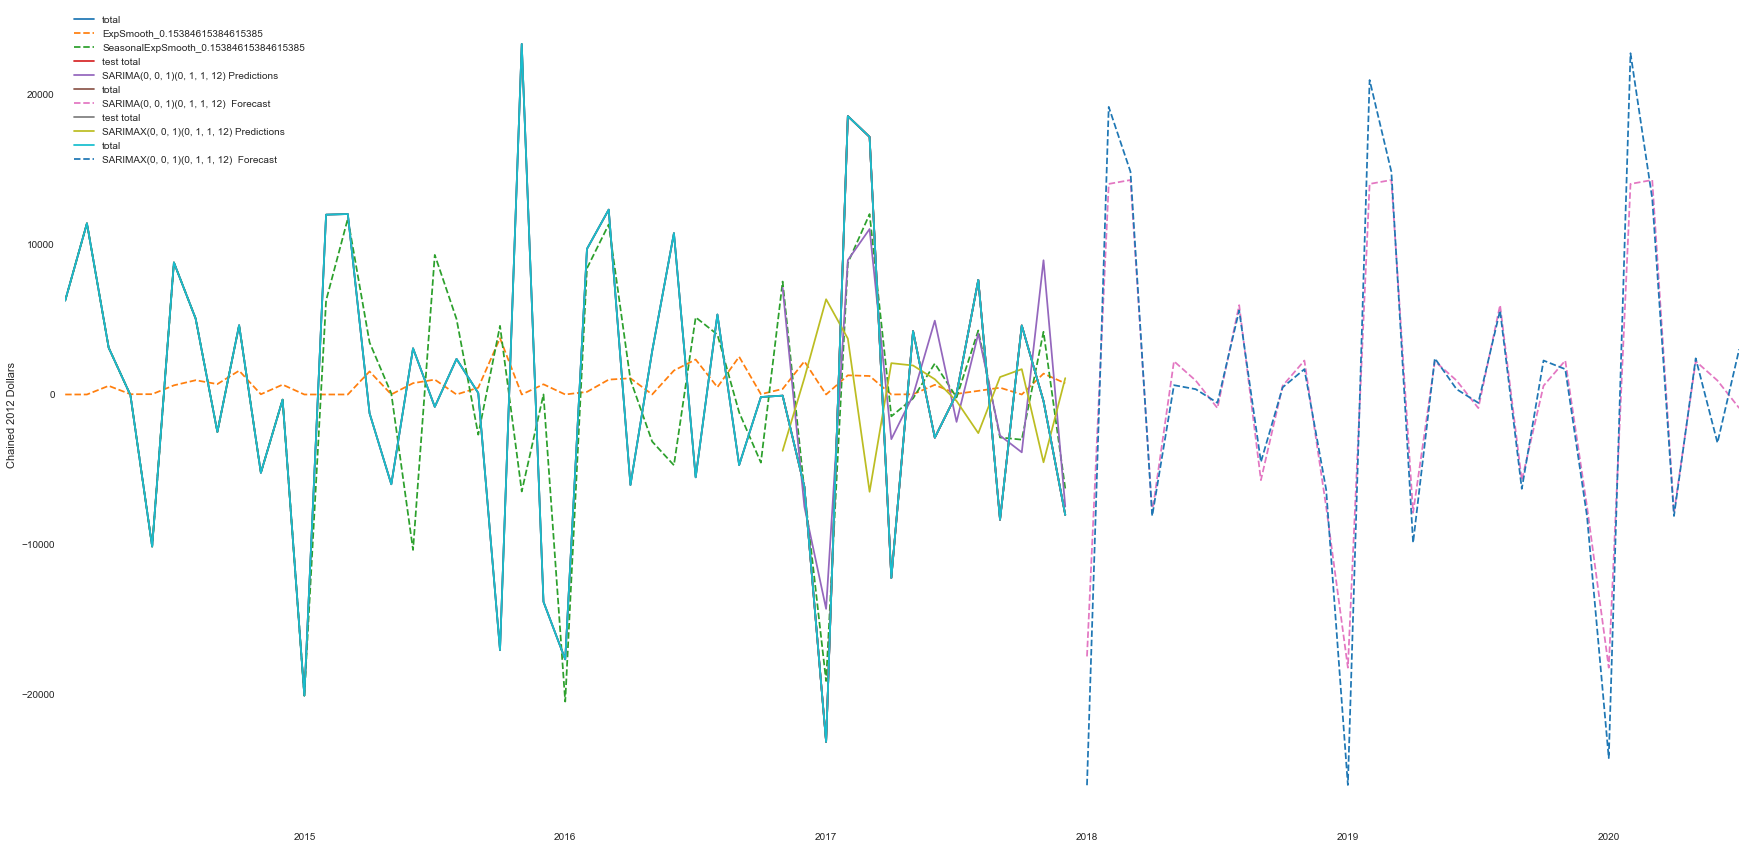

In [287]:
for what in ['SMOOTHING','SARIMA','SARIMAX']:
    MakePredictionsTestAndForecast(what,dfMonth['2014-01-01':],'total',testPercentSize=30,
                               seasonal=True,seasonalM=12,futureEstimation=30,exogField='weekType',figsizeX=30,figsizeY=15)

In [37]:
# CORRELATION
from scipy import stats
stats.pearsonr(df['Agravo de Instrumento'],df['Apelação Cível'])[0]

0.8517789826139527

In [38]:
rowCorr=[]
for i in dfUniqueTypes:
    for i2 in dfUniqueTypes:
        if i != i2:
            result = stats.pearsonr(df[i],df[i2])
            print(f'{i} e {i2}: {result}')
            rowCorr.append({'type':i,'type_2':i2,'valor':result[0],'valor_2':result[1]})

Agravo de Instrumento e Apelação Cível: (0.8517789826139527, 0.0)
Agravo de Instrumento e Apelação e Reexame Necessário: (0.673986148937784, 7.705874002144071e-194)
Agravo de Instrumento e Agravo: (0.7332873312929747, 2.2110895780562997e-246)
Agravo de Instrumento e Reexame Necessário: (0.5369271587615189, 9.815889545441628e-110)
Agravo de Instrumento e Agravo Regimental: (0.5520112837317089, 3.912835968684943e-117)
Agravo de Instrumento e Embargos de Declaração: (0.8678064221156034, 0.0)
Agravo de Instrumento e Apelação Crime: (0.6205916965793373, 4.502014521296617e-156)
Agravo de Instrumento e Ação Rescisória: (0.28213398472451523, 4.201525261566258e-28)
Agravo de Instrumento e Conflito de Competência: (0.7309831170068448, 4.4329188263740523e-244)
Agravo de Instrumento e Agravo Interno: (0.30074103671280117, 7.011991117114011e-32)
Agravo de Instrumento e Exceção de Suspeição: (0.40513471016156477, 9.71716963335776e-59)
Agravo de Instrumento e Mandado de Segurança: (0.4736096887712952

Apelação Crime e Processo Crime: (nan, nan)
Apelação Crime e Recurso de Ofício: (0.3999692334796987, 3.6583886968191547e-57)
Apelação Crime e Correição Parcial: (0.6522074068524557, 1.6490877153524974e-177)
Apelação Crime e Conflito de Jurisdição: (0.7348956578863975, 5.290155950818098e-248)
Apelação Crime e Agravo Lei: (nan, nan)
Apelação Crime e Queixa: (nan, nan)
Apelação Crime e Agravo em Execução: (nan, nan)
Apelação Crime e Recurso de Agravo: (nan, nan)
Apelação Crime e Agravo Inominado: (nan, nan)
Apelação Crime e Cautelar Incidental: (nan, nan)
Apelação Crime e Desaforamento: (0.2917168864618145, 5.1659903644146156e-30)
Apelação Crime e Embargos Infringentes: (-0.05641525436742311, 0.031181032752118375)
Apelação Crime e Embargos à Execução: (nan, nan)
Apelação Crime e Cautelar Inominada: (0.19212153203761245, 1.3496009793591088e-13)
Apelação Crime e Carta Testemunhável: (0.3838734629145441, 1.983758097959026e-52)
Apelação Crime e Habeas Data: (-0.015099875029701807, 0.564408163

Mandado de Segurança e Crimes contra a honra: (-0.0062720898666042725, 0.8108178009936364)
Mandado de Segurança e Declaratória de Constitucionalidade: (0.051961863661593305, 0.0472090990134483)
Mandado de Segurança e Arresto: (nan, nan)
Mandado de Segurança e Outras Medidas Provisionais: (nan, nan)
Mandado de Segurança e Representação Criminal: (0.08922887348864296, 0.0006445277679230232)
Mandado de Segurança e Incidente de Uniformizacao Jurisprudencia: (0.06003146712813428, 0.0218413042544125)
Mandado de Segurança e Crime Responsabilidade Funcionário Publico: (nan, nan)
Mandado de Segurança e Arresto Hipoteca Legal: (nan, nan)
Mandado de Segurança e Incidente de Falsidade: (0.0744164277683266, 0.0044553639384681595)
Mandado de Segurança e Investigação Contra Magistrado: (0.040010578941235275, 0.12661679392664327)
Mandado de Segurança e Ação Civil Improbidade Administrativa: (0.028586496597751122, 0.27518423110329204)
Mandado de Segurança e Suspensão de Execução de Sentença: (nan, nan)

Medida Cautelar Inominada e Exceção Suspeição Impedimento: (nan, nan)
Medida Cautelar Inominada e Mandado de Segurança Crime: (-0.02204386034799819, 0.40013129197558317)
Medida Cautelar Inominada e Impugnação: (nan, nan)
Medida Cautelar Inominada e Recurso Extraordinário: (-0.04070065048546092, 0.12019672085662302)
Medida Cautelar Inominada e Embargos: (nan, nan)
Medida Cautelar Inominada e Recurso Especial: (-0.04107239061295559, 0.11684534382408901)
Medida Cautelar Inominada e Outros Crimes: (nan, nan)
Medida Cautelar Inominada e Pedido Suspensão Liminar: (nan, nan)
Medida Cautelar Inominada e Suspenção de Liminar ou Antecipação de Tutela: (0.03787187561957614, 0.14821492702880926)
Medida Cautelar Inominada e Petição: (0.02886096527712288, 0.2705995816177471)
Medida Cautelar Inominada e Intervenção em Município: (-0.008813413887531662, 0.7365973576429516)
Medida Cautelar Inominada e Crimes Ambientais: (nan, nan)
Medida Cautelar Inominada e Embargos Infringentes e de Nulidade: (0.0017

Correição Parcial e Incidente de Falsidade: (0.06837967117249384, 0.008982789069252978)
Correição Parcial e Investigação Contra Magistrado: (0.0045487605467383245, 0.8621795622603785)
Correição Parcial e Ação Civil Improbidade Administrativa: (0.012074815505171881, 0.6449123163357688)
Correição Parcial e Suspensão de Execução de Sentença: (nan, nan)
Correição Parcial e Incidente de Prevenção ou Composição de Divergência: (nan, nan)
Correição Parcial e Embargos de Terceiros: (nan, nan)
Correição Parcial e Mandado de Segurança Coletivo: (0.014278117023081047, 0.5857950912163029)
Correição Parcial e Impugnação ao Cumprimento de Sentença: (-0.0016432670575713668, 0.9499943411890049)
Correição Parcial e Oposição: (nan, nan)
Correição Parcial e Cumprimento de Sentença: (0.044877078152157454, 0.08661001977949252)
Correição Parcial e Liquidação Provisória por Artigos: (0.05979979521941234, 0.022356785905765342)
Correição Parcial e Notificação Para Explicações: (nan, nan)
Correição Parcial e Me

Desaforamento e Restauração de Autos: (0.027381382655263124, 0.29593870289005414)
Desaforamento e Declaração de Inconstitucionalidade: (nan, nan)
Desaforamento e Uniformização de Jurisprudência: (-0.013693634469810716, 0.6012317471724619)
Desaforamento e Mandado de Injunção: (0.06518740427994711, 0.012757457706133065)
Desaforamento e Apelação Rec: (nan, nan)
Desaforamento e Notícia Crime: (-0.01147244726227752, 0.6614948292559251)
Desaforamento e Ação Civil Pública: (nan, nan)
Desaforamento e Apelação Recurso de Ofício: (nan, nan)
Desaforamento e Recurso Oficioso em Sentido Estrito: (nan, nan)
Desaforamento e Prefeito: (-0.00467556920907862, 0.8583774681214642)
Desaforamento e Revisão Criminal: (-0.047733634789347175, 0.06834107881002506)
Desaforamento e Reabilitação: (-0.006614522131016462, 0.8007008460979572)
Desaforamento e Recurso Inominado: (nan, nan)
Desaforamento e Habilitação: (nan, nan)
Desaforamento e Ação Direta de Inconstitucionalidade: (-0.034197538467066045, 0.19172237013

Carta Testemunhável e Recurso em Sentido Estrito: (0.2922378062118712, 4.047432574658505e-30)
Carta Testemunhável e Processo Crime: (nan, nan)
Carta Testemunhável e Recurso de Ofício: (0.08762003092476318, 0.0008069881737140035)
Carta Testemunhável e Correição Parcial: (0.24471085720253566, 2.4536435605005876e-21)
Carta Testemunhável e Conflito de Jurisdição: (0.22825795122113962, 1.0650910601169992e-18)
Carta Testemunhável e Agravo Lei: (nan, nan)
Carta Testemunhável e Queixa: (nan, nan)
Carta Testemunhável e Agravo em Execução: (nan, nan)
Carta Testemunhável e Recurso de Agravo: (nan, nan)
Carta Testemunhável e Agravo Inominado: (nan, nan)
Carta Testemunhável e Cautelar Incidental: (nan, nan)
Carta Testemunhável e Desaforamento: (0.1864500075063369, 7.03575732396095e-13)
Carta Testemunhável e Embargos Infringentes: (-0.03352244907333634, 0.2006455834642829)
Carta Testemunhável e Embargos à Execução: (nan, nan)
Carta Testemunhável e Cautelar Inominada: (0.07257816815284199, 0.00554499

Termo Circunstanciado e Liquidação Provisória por Artigos: (-0.003814661426834828, 0.8842500145821643)
Termo Circunstanciado e Notificação Para Explicações: (nan, nan)
Termo Circunstanciado e Medidas Protetivas de Urgencia: (-0.0066117237511119755, 0.8007833898405433)
Termo Circunstanciado e Recurso Especial e ou Extraordinário: (0.01787996927878981, 0.4949684502637635)
Termo Circunstanciado e Incidente de Resolucao de Demandas Repetitiva: (-0.0036739064575017763, 0.8884925845330485)
Termo Circunstanciado e Suspensão de Liminar ou Antecipação de Tutela: (-0.012273279278830507, 0.6394867352883224)
Termo Circunstanciado e Reclamação Regimental: (-0.012695412644622282, 0.6280106429684359)
Termo Circunstanciado e Incidente de Assunção de Competência: (-0.006611723751111977, 0.8007833898405433)
Termo Circunstanciado e Agravo em Rec: (-0.005396596927950509, 0.8368238170508302)
Termo Circunstanciado e Tutela Cautelar Antecedente: (-0.008101849173288761, 0.7571655741627845)
Termo Circunstancia

Pedido de Assistência Judiciária Gratuita e Cumprimento de Sentença: (-0.005396026797009081, 0.8368408139344087)
Pedido de Assistência Judiciária Gratuita e Liquidação Provisória por Artigos: (-0.0015357624224344461, 0.9532619039681812)
Pedido de Assistência Judiciária Gratuita e Notificação Para Explicações: (nan, nan)
Pedido de Assistência Judiciária Gratuita e Medidas Protetivas de Urgencia: (-0.002661844852873426, 0.9190843815530747)
Pedido de Assistência Judiciária Gratuita e Recurso Especial e ou Extraordinário: (-0.004493537124289147, 0.8638363247080796)
Pedido de Assistência Judiciária Gratuita e Incidente de Resolucao de Demandas Repetitiva: (-0.008577779184942682, 0.7433884927252542)
Pedido de Assistência Judiciária Gratuita e Suspensão de Liminar ou Antecipação de Tutela: (-0.004941157027430045, 0.8504250953028937)
Pedido de Assistência Judiciária Gratuita e Reclamação Regimental: (-0.005111105677624316, 0.8453443117189395)
Pedido de Assistência Judiciária Gratuita e Inciden

Apelação Rec e Conflito de Jurisdição: (nan, nan)
Apelação Rec e Agravo Lei: (nan, nan)
Apelação Rec e Queixa: (nan, nan)
Apelação Rec e Agravo em Execução: (nan, nan)
Apelação Rec e Recurso de Agravo: (nan, nan)
Apelação Rec e Agravo Inominado: (nan, nan)
Apelação Rec e Cautelar Incidental: (nan, nan)
Apelação Rec e Desaforamento: (nan, nan)
Apelação Rec e Embargos Infringentes: (nan, nan)
Apelação Rec e Embargos à Execução: (nan, nan)
Apelação Rec e Cautelar Inominada: (nan, nan)
Apelação Rec e Carta Testemunhável: (nan, nan)
Apelação Rec e Habeas Data: (nan, nan)
Apelação Rec e Termo Circunstanciado: (nan, nan)
Apelação Rec e Exceção da Verdade: (nan, nan)
Apelação Rec e Inquérito Policial: (nan, nan)
Apelação Rec e Interpelação Judicial: (nan, nan)
Apelação Rec e Exceção de Incompetência: (nan, nan)
Apelação Rec e Representação: (nan, nan)
Apelação Rec e Pedido de Assistência Judiciária Gratuita: (nan, nan)
Apelação Rec e Impugnação à Assistência Judiciária: (nan, nan)
Apelação Rec

Revisão Criminal e Mandado de Segurança: (0.27497784291749594, 1.0042697168728419e-26)
Revisão Criminal e Habeas Corpus: (-0.06518786194533208, 0.012756828664693291)
Revisão Criminal e Outros Feitos: (nan, nan)
Revisão Criminal e Impugnação ao Valor da Causa: (0.3277427104090006, 7.084101530822556e-38)
Revisão Criminal e Medida Cautelar: (-0.008566257237997602, 0.7437210791688967)
Revisão Criminal e Medida Cautelar Inominada: (-0.0016287154210377524, 0.9504365847545145)
Revisão Criminal e Outros Incidentes: (nan, nan)
Revisão Criminal e Recurso Crime: (-0.02873375114118574, 0.27271798771535705)
Revisão Criminal e Recurso em Sentido Estrito: (-0.08609487626809367, 0.0009953107917814816)
Revisão Criminal e Processo Crime: (nan, nan)
Revisão Criminal e Recurso de Ofício: (-0.02886882709786158, 0.2704690350550433)
Revisão Criminal e Correição Parcial: (-0.02703424557441844, 0.30210641009827743)
Revisão Criminal e Conflito de Jurisdição: (-0.06285180596233904, 0.016347744323342732)
Revisão 

Ação Direta de Inconstitucionalidade e Suspensão de Liminar ou Antecipação de Tutela: (-0.014991845855007199, 0.567198162865633)
Ação Direta de Inconstitucionalidade e Reclamação Regimental: (-0.01936781698671022, 0.4597703618989148)
Ação Direta de Inconstitucionalidade e Incidente de Assunção de Competência: (-0.002044896684376658, 0.9377948307323236)
Ação Direta de Inconstitucionalidade e Agravo em Rec: (0.06068740895192627, 0.020437450239296315)
Ação Direta de Inconstitucionalidade e Tutela Cautelar Antecedente: (-0.012359986747548133, 0.6371223474781591)
Ação Direta de Inconstitucionalidade e Tutela Antecipada Antecedente: (-0.013599707840544473, 0.6037294379173815)
Ação Direta de Inconstitucionalidade e Tutela Provisoria: (-0.01750676348926886, 0.5040177849558499)
Ação Direta de Inconstitucionalidade e Agravo de Instrumento em Recurso Extraordinario: (-0.005819555964767773, 0.8242359482518129)
Ação Direta de Inconstitucionalidade e Interpelação: (-0.005819555964767773, 0.824235948

Intervenção Federal no Estado e Ação Civil Improbidade Administrativa: (nan, nan)
Intervenção Federal no Estado e Suspensão de Execução de Sentença: (nan, nan)
Intervenção Federal no Estado e Incidente de Prevenção ou Composição de Divergência: (nan, nan)
Intervenção Federal no Estado e Embargos de Terceiros: (nan, nan)
Intervenção Federal no Estado e Mandado de Segurança Coletivo: (nan, nan)
Intervenção Federal no Estado e Impugnação ao Cumprimento de Sentença: (nan, nan)
Intervenção Federal no Estado e Oposição: (nan, nan)
Intervenção Federal no Estado e Cumprimento de Sentença: (nan, nan)
Intervenção Federal no Estado e Liquidação Provisória por Artigos: (nan, nan)
Intervenção Federal no Estado e Notificação Para Explicações: (nan, nan)
Intervenção Federal no Estado e Medidas Protetivas de Urgencia: (nan, nan)
Intervenção Federal no Estado e Recurso Especial e ou Extraordinário: (nan, nan)
Intervenção Federal no Estado e Incidente de Resolucao de Demandas Repetitiva: (nan, nan)
Inte

Mandado de Segurança Crime e Investigação Contra Magistrado: (-0.0016225325140240456, 0.9506244961369713)
Mandado de Segurança Crime e Ação Civil Improbidade Administrativa: (-0.0059528086740444665, 0.8202793314142043)
Mandado de Segurança Crime e Suspensão de Execução de Sentença: (nan, nan)
Mandado de Segurança Crime e Incidente de Prevenção ou Composição de Divergência: (nan, nan)
Mandado de Segurança Crime e Embargos de Terceiros: (nan, nan)
Mandado de Segurança Crime e Mandado de Segurança Coletivo: (0.0038515262464809746, 0.8831393952091988)
Mandado de Segurança Crime e Impugnação ao Cumprimento de Sentença: (-0.004858779678691594, 0.8528900958638898)
Mandado de Segurança Crime e Oposição: (nan, nan)
Mandado de Segurança Crime e Cumprimento de Sentença: (0.0038515262464809867, 0.8831393952091988)
Mandado de Segurança Crime e Liquidação Provisória por Artigos: (-0.0034344976416151862, 0.8957160028939632)
Mandado de Segurança Crime e Notificação Para Explicações: (nan, nan)
Mandado

Recurso Especial e Crimes contra a honra: (-0.034112854055817786, 0.19282544380491426)
Recurso Especial e Declaratória de Constitucionalidade: (0.02619292807732649, 0.3174065370723913)
Recurso Especial e Arresto: (nan, nan)
Recurso Especial e Outras Medidas Provisionais: (nan, nan)
Recurso Especial e Representação Criminal: (0.02276536749531612, 0.38488386968590904)
Recurso Especial e Incidente de Uniformizacao Jurisprudencia: (0.08359947994059815, 0.0013930044506515304)
Recurso Especial e Crime Responsabilidade Funcionário Publico: (nan, nan)
Recurso Especial e Arresto Hipoteca Legal: (nan, nan)
Recurso Especial e Incidente de Falsidade: (-0.011983637369207234, 0.647411303178556)
Recurso Especial e Investigação Contra Magistrado: (0.005240271105060965, 0.8414870642792305)
Recurso Especial e Ação Civil Improbidade Administrativa: (0.011727970393390396, 0.6544396892664351)
Recurso Especial e Suspensão de Execução de Sentença: (nan, nan)
Recurso Especial e Incidente de Prevenção ou Compo

Intervenção em Município e Intervenção no Estado: (-0.001942601505390418, 0.9409007795837443)
Intervenção em Município e Procedimento Investigatório do MP: (-0.0033693126851459493, 0.8976842793608196)
Intervenção em Município e Ação Penal: (-0.011531949845178063, 0.6598492150351397)
Intervenção em Município e Crimes contra a honra: (-0.004971483801252274, 0.8495179850327212)
Intervenção em Município e Declaratória de Constitucionalidade: (-0.0013731555514075325, 0.9582057523334458)
Intervenção em Município e Arresto: (nan, nan)
Intervenção em Município e Outras Medidas Provisionais: (nan, nan)
Intervenção em Município e Representação Criminal: (-0.012414334883457495, 0.6356422293196632)
Intervenção em Município e Incidente de Uniformizacao Jurisprudencia: (-0.0066075786292685715, 0.8009056624805277)
Intervenção em Município e Crime Responsabilidade Funcionário Publico: (nan, nan)
Intervenção em Município e Arresto Hipoteca Legal: (nan, nan)
Intervenção em Município e Incidente de Falsi

Ação Penal e Apelação Cível: (0.2816281989300319, 5.274420165868497e-28)
Ação Penal e Apelação e Reexame Necessário: (0.07295796007521249, 0.005301939948654088)
Ação Penal e Agravo: (0.23993491679607257, 1.500323022421588e-20)
Ação Penal e Reexame Necessário: (0.046258457265010273, 0.07733565400809217)
Ação Penal e Agravo Regimental: (0.19654937397890343, 3.587403033131545e-14)
Ação Penal e Embargos de Declaração: (0.21962499447335515, 2.1459973142627026e-17)
Ação Penal e Apelação Crime: (0.33818419564218116, 2.3043046024949803e-40)
Ação Penal e Ação Rescisória: (0.03897371812583577, 0.13676065436887347)
Ação Penal e Conflito de Competência: (0.18664811458395994, 6.647191183359878e-13)
Ação Penal e Agravo Interno: (0.1601800832208483, 7.607830200679141e-10)
Ação Penal e Exceção de Suspeição: (0.12378984117418262, 2.110113026977758e-06)
Ação Penal e Mandado de Segurança: (0.17794179511728558, 7.610620875528254e-12)
Ação Penal e Habeas Corpus: (0.30285718586390653, 2.501642695515194e-32)

Representação Criminal e Recurso de Agravo: (nan, nan)
Representação Criminal e Agravo Inominado: (nan, nan)
Representação Criminal e Cautelar Incidental: (nan, nan)
Representação Criminal e Desaforamento: (0.09533336240743767, 0.0002657103495181082)
Representação Criminal e Embargos Infringentes: (0.007235359691137084, 0.782444569251793)
Representação Criminal e Embargos à Execução: (nan, nan)
Representação Criminal e Cautelar Inominada: (0.04361221680224055, 0.09587002937443093)
Representação Criminal e Carta Testemunhável: (0.06687033576899522, 0.010621598935191478)
Representação Criminal e Habeas Data: (0.016950159002601602, 0.5176744119717471)
Representação Criminal e Termo Circunstanciado: (0.09481249464898271, 0.00028716911157499034)
Representação Criminal e Exceção da Verdade: (-0.01074743673729791, 0.6816751467225608)
Representação Criminal e Inquérito Policial: (0.11234227957144059, 1.6997836702454347e-05)
Representação Criminal e Interpelação Judicial: (nan, nan)
Representaç

Incidente de Falsidade e Liquidação Provisória por Artigos: (-0.0015357624224344457, 0.9532619039681812)
Incidente de Falsidade e Notificação Para Explicações: (nan, nan)
Incidente de Falsidade e Medidas Protetivas de Urgencia: (-0.0026618448528734264, 0.9190843815530747)
Incidente de Falsidade e Recurso Especial e ou Extraordinário: (-0.0012473549546597007, 0.9620316662320945)
Incidente de Falsidade e Incidente de Resolucao de Demandas Repetitiva: (0.05247090291667364, 0.04508223957509983)
Incidente de Falsidade e Suspensão de Liminar ou Antecipação de Tutela: (-0.004941157027430048, 0.8504250953028937)
Incidente de Falsidade e Reclamação Regimental: (-0.005111105677624319, 0.8453443117189395)
Incidente de Falsidade e Incidente de Assunção de Competência: (-0.002661844852873427, 0.9190843815530747)
Incidente de Falsidade e Agravo em Rec: (-0.002172641250064585, 0.9339175046542961)
Incidente de Falsidade e Tutela Cautelar Antecedente: (-0.003261761430526882, 0.9009331866505779)
Inciden

Mandado de Segurança Coletivo e Reabilitação: (-0.0034092317219588854, 0.8964788383875477)
Mandado de Segurança Coletivo e Recurso Inominado: (nan, nan)
Mandado de Segurança Coletivo e Habilitação: (nan, nan)
Mandado de Segurança Coletivo e Ação Direta de Inconstitucionalidade: (0.05989868218592922, 0.022135478839443928)
Mandado de Segurança Coletivo e Agravo Embargos Infringentes: (nan, nan)
Mandado de Segurança Coletivo e Embargos de Nulidade: (nan, nan)
Mandado de Segurança Coletivo e Recurso Cível: (0.01150718031531401, 0.6605340464965307)
Mandado de Segurança Coletivo e Incidente de Inconstitucionalidade: (0.04366841515176675, 0.09544243969817409)
Mandado de Segurança Coletivo e Agravo de Petição: (nan, nan)
Mandado de Segurança Coletivo e Processo de Execução: (nan, nan)
Mandado de Segurança Coletivo e Intervenção Federal no Estado: (nan, nan)
Mandado de Segurança Coletivo e Pedido de Arquivamento: (nan, nan)
Mandado de Segurança Coletivo e Reclamação: (0.038596111463222116, 0.14

Liquidação Provisória por Artigos e Apelação e Reexame Necessário: (0.03936142882396864, 0.13289664229940412)
Liquidação Provisória por Artigos e Agravo: (0.09579616009548664, 0.00024791301509992543)
Liquidação Provisória por Artigos e Reexame Necessário: (0.044632854573730035, 0.08833944879755647)
Liquidação Provisória por Artigos e Agravo Regimental: (0.11510518067936563, 1.0454900688200855e-05)
Liquidação Provisória por Artigos e Embargos de Declaração: (0.08995568697861366, 0.0005815942237383001)
Liquidação Provisória por Artigos e Apelação Crime: (0.08894312999252071, 0.0006709590850097726)
Liquidação Provisória por Artigos e Ação Rescisória: (0.003973446682681203, 0.8794679673586802)
Liquidação Provisória por Artigos e Conflito de Competência: (0.058077860510750756, 0.02653008718498763)
Liquidação Provisória por Artigos e Agravo Interno: (0.05048301085320886, 0.05387142263407011)
Liquidação Provisória por Artigos e Exceção de Suspeição: (0.09441525405277285, 0.0003046134620619702

Recurso Especial e ou Extraordinário e Embargos de Nulidade: (nan, nan)
Recurso Especial e ou Extraordinário e Recurso Cível: (0.1241543438338079, 1.968265328895126e-06)
Recurso Especial e ou Extraordinário e Incidente de Inconstitucionalidade: (0.09576448006277115, 0.0002490947692808774)
Recurso Especial e ou Extraordinário e Agravo de Petição: (nan, nan)
Recurso Especial e ou Extraordinário e Processo de Execução: (nan, nan)
Recurso Especial e ou Extraordinário e Intervenção Federal no Estado: (nan, nan)
Recurso Especial e ou Extraordinário e Pedido de Arquivamento: (nan, nan)
Recurso Especial e ou Extraordinário e Reclamação: (0.26337062666136496, 1.4182491078140012e-24)
Recurso Especial e ou Extraordinário e Outros Cíveis: (nan, nan)
Recurso Especial e ou Extraordinário e Exceção Suspeição Impedimento: (nan, nan)
Recurso Especial e ou Extraordinário e Mandado de Segurança Crime: (0.049302632030261716, 0.05973607580680159)
Recurso Especial e ou Extraordinário e Impugnação: (nan, nan

Agravo em Rec e Mandado de Segurança Coletivo: (0.17423609264725598, 2.0716151428010144e-11)
Agravo em Rec e Impugnação ao Cumprimento de Sentença: (-0.00137268359643102, 0.9582201039344455)
Agravo em Rec e Oposição: (nan, nan)
Agravo em Rec e Cumprimento de Sentença: (-0.0034092317219588876, 0.8964788383875477)
Agravo em Rec e Liquidação Provisória por Artigos: (-0.0009703009575226802, 0.970460534413156)
Agravo em Rec e Notificação Para Explicações: (nan, nan)
Agravo em Rec e Medidas Protetivas de Urgencia: (-0.001681764426444125, 0.9488244295638555)
Agravo em Rec e Recurso Especial e ou Extraordinário: (0.017157738396699998, 0.5125590572129254)
Agravo em Rec e Incidente de Resolucao de Demandas Repetitiva: (-0.005419475847946935, 0.8361418079534854)
Agravo em Rec e Suspensão de Liminar ou Antecipação de Tutela: (-0.0031218431477085615, 0.9051623114002392)
Agravo em Rec e Reclamação Regimental: (-0.0032292173975302313, 0.9019166058627447)
Agravo em Rec e Incidente de Assunção de Compe

Interpelação e Suspensão de Liminar ou Antecipação de Tutela: (0.26609356984029914, 4.537967808536464e-25)
Interpelação e Reclamação Regimental: (-0.0022826183258976, 0.9305807112297513)
Interpelação e Incidente de Assunção de Competência: (-0.0011887791458636474, 0.96381340796474)
Interpelação e Agravo em Rec: (-0.0009703009575226793, 0.970460534413156)
Interpelação e Tutela Cautelar Antecedente: (-0.001456701716934025, 0.9556654282863682)
Interpelação e Tutela Antecipada Antecedente: (-0.0016028105988909831, 0.9512239043659723)
Interpelação e Tutela Provisoria: (-0.0020632815353005735, 0.9372367174724359)
Interpelação e Agravo de Instrumento em Recurso Extraordinario: (-0.0006858710562414266, 0.9791172228401701)


In [39]:
rowCorr

[{'type': 'Agravo de Instrumento',
  'type_2': 'Apelação Cível',
  'valor': 0.8517789826139527,
  'valor_2': 0.0},
 {'type': 'Agravo de Instrumento',
  'type_2': 'Apelação e Reexame Necessário',
  'valor': 0.673986148937784,
  'valor_2': 7.705874002144071e-194},
 {'type': 'Agravo de Instrumento',
  'type_2': 'Agravo',
  'valor': 0.7332873312929747,
  'valor_2': 2.2110895780562997e-246},
 {'type': 'Agravo de Instrumento',
  'type_2': 'Reexame Necessário',
  'valor': 0.5369271587615189,
  'valor_2': 9.815889545441628e-110},
 {'type': 'Agravo de Instrumento',
  'type_2': 'Agravo Regimental',
  'valor': 0.5520112837317089,
  'valor_2': 3.912835968684943e-117},
 {'type': 'Agravo de Instrumento',
  'type_2': 'Embargos de Declaração',
  'valor': 0.8678064221156034,
  'valor_2': 0.0},
 {'type': 'Agravo de Instrumento',
  'type_2': 'Apelação Crime',
  'valor': 0.6205916965793373,
  'valor_2': 4.502014521296617e-156},
 {'type': 'Agravo de Instrumento',
  'type_2': 'Ação Rescisória',
  'valor': 0

In [40]:
rowCorr = pd.DataFrame(rowCorr)
rowCorr.drop_duplicates()

,type,type_2,valor,valor_2
0,Agravo de Instrumento,Apelação Cível,0.851779,0.000000e+00
1,Agravo de Instrumento,Apelação e Reexame Necessário,0.673986,7.705874e-194
2,Agravo de Instrumento,Agravo,0.733287,2.211090e-246
3,Agravo de Instrumento,Reexame Necessário,0.536927,9.815890e-110
4,Agravo de Instrumento,Agravo Regimental,0.552011,3.912836e-117
...,...,...,...,...
14037,Interpelação,Agravo em Rec,-0.000970,9.704605e-01
14038,Interpelação,Tutela Cautelar Antecedente,-0.001457,9.556654e-01
14039,Interpelação,Tutela Antecipada Antecedente,-0.001603,9.512239e-01
14040,Interpelação,Tutela Provisoria,-0.002063,9.372367e-01


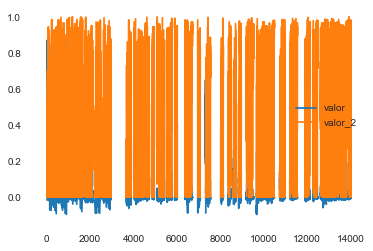

In [48]:
rowCorr.plot()

Text(0.5, 0.98, 'Smiling data and rolling window correlation')

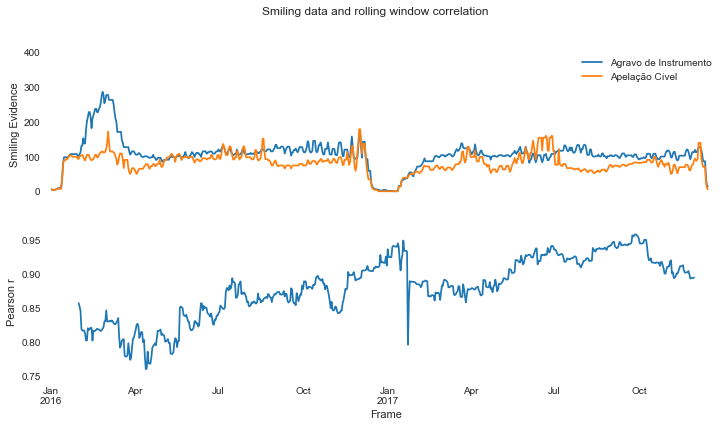

In [75]:
# Set window size to compute moving window synchrony.
r_window_size = 60
# Interpolate missing data.
df_interpolated = df[['Agravo de Instrumento','Apelação Cível']]['2016-01-01':].interpolate()
# Compute rolling window synchrony
rolling_r = df_interpolated['Apelação Cível'].rolling(window=r_window_size, center=True).corr(df_interpolated['Agravo de Instrumento'])
f,ax=plt.subplots(2,1,figsize=(12,6),sharex=True)
df[['Agravo de Instrumento','Apelação Cível']].rolling(window=30,center=True).median().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Smiling Evidence')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Pearson r')
plt.suptitle("Smiling data and rolling window correlation")

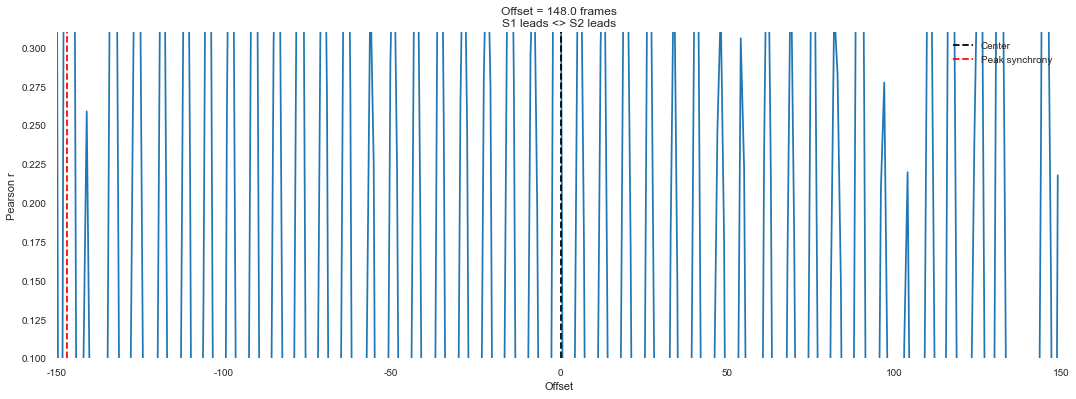

In [74]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))
    
dfR = df['2016-01-01':'2016-06-01'].copy()

d1 = dfR['Agravo de Instrumento']
d2 = dfR['Apelação Cível']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(18,6))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.1,.31],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()